### In this notebook we'll perform EDA.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
#import the cleaned and compiled dataset and sort by Date
df = pd.read_csv('working_datasets/df_cleaned_compiled.csv')
df = df.sort_values(by='Date')

Since this notebook is independent of the modeling, we can convert the target classes back to more descriptive strings rather than numbers. Let's do that below.

In [3]:
risk_class_mapping = {
    1: 'high',
    2: 'medium',
    3: 'low'
}
df['credit_risk'] = df['Rating'].map(lambda x: risk_class_mapping.get(x))
df.drop('Rating', axis=1, inplace=True)

We have a lot of features in our dataset that we can explore. For the scope of this project, we'll be selecting a few of the most important feautures (based on subjectivity) and use those for our data exploration questions.  

Note* that in our data compilation phase, we have introduced some additional variables for reference in exploration. These variables are not included in the actual model; the model only includes all the features in the original dataset from Kaggle.

All the variables in our dataset are listed below.

In [4]:
df.columns

Index(['Name', 'Symbol', 'Rating Agency Name', 'Date', 'Sector',
       'currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
       'netProfitMargin', 'pretaxProfitMargin', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnCapitalEmployed',
       'returnOnEquity', 'assetTurnover', 'fixedAssetTurnover',
       'debtEquityRatio', 'debtRatio', 'effectiveTaxRate',
       'freeCashFlowOperatingCashFlowRatio', 'freeCashFlowPerShare',
       'cashPerShare', 'companyEquityMultiplier', 'ebitPerRevenue',
       'enterpriseValueMultiple', 'operatingCashFlowPerShare',
       'operatingCashFlowSalesRatio', 'payablesTurnover', 'risk_free_rate',
       'ten_yr_t_note_yield', 'stock_price', 'ytd_equity_return',
       'last_div_amount', 'last_div_date', 'cpi_index', 'credit_risk'],
      dtype='object')

 #### 1. Which variables or groups of variables are closely related to each other?

When looking at company financials from a machine learning perspective, we'll see that a number of variable pairs, or groups of multiple variables, will be collinear. For example, something like gross profit margin and net profit margin will surely be highly collinear to a machine learning model when using a reasonably-sized dataset.

Let's take a look at what collinear pairs/groups we have in our dataset. First, we'll plot a heatmap of correlation coefficients and look at all the variable pairs with correlation coefficients above 0.8.



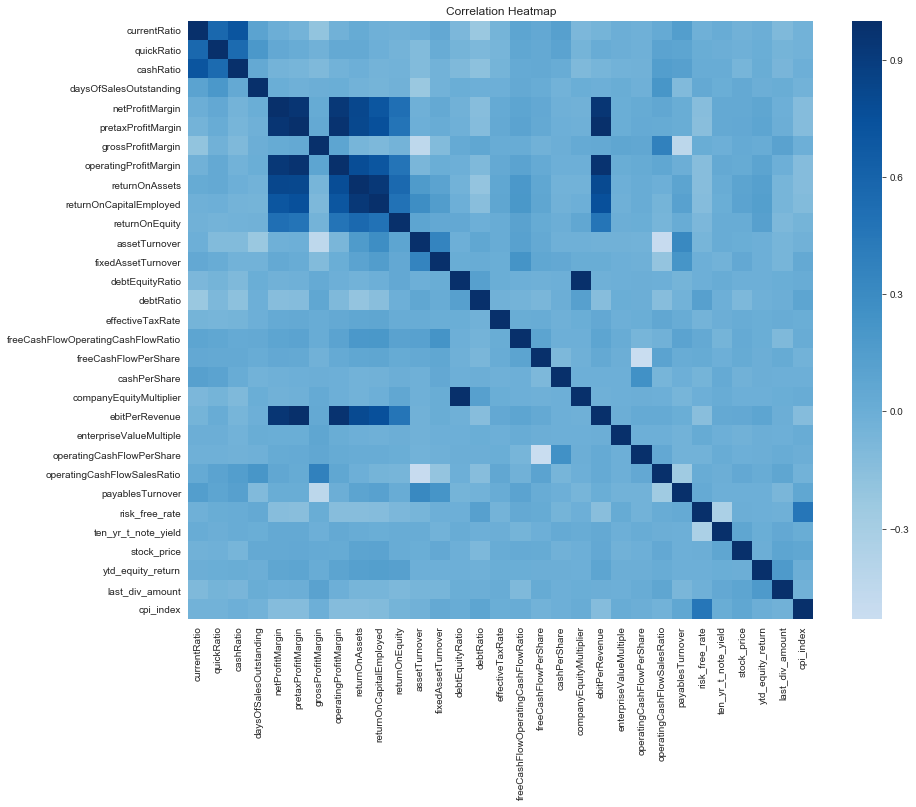

== Variable pairs with correlations > 0.8 ==


,pairs,corr
1,"(companyEquityMultiplier, debtEquityRatio)",0.999988
2,"(ebitPerRevenue, pretaxProfitMargin)",0.999905
3,"(ebitPerRevenue, operatingProfitMargin)",0.998310
4,"(netProfitMargin, pretaxProfitMargin)",0.998057
5,"(operatingProfitMargin, pretaxProfitMargin)",0.998029
6,"(ebitPerRevenue, netProfitMargin)",0.997980
7,"(netProfitMargin, operatingProfitMargin)",0.997032
8,"(returnOnAssets, returnOnCapitalEmployed)",0.992007
9,"(netProfitMargin, returnOnAssets)",0.965993
10,"(pretaxProfitMargin, returnOnAssets)",0.964709


In [5]:
df_corr = df.corr()
#plot multi-collinearity correlation heatmap 
plt.figure(figsize=(14, 11))
sns.heatmap(df_corr, center=0, cmap="Blues")
plt.title('Correlation Heatmap')

#generate multi-collinearity df for variable pairs 
#with correlation coefficients above 0.8
df_corr = df_corr.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = df_corr.apply(lambda row: tuple(sorted([row['level_0'], row['level_1']])), axis=1)
df_corr = df_corr[['pairs', 0]].rename(columns={0: 'corr'})
df_corr = df_corr.query("corr > 0.8 and corr < 1")
df_corr.drop_duplicates(inplace=True)
df_corr.index = df_corr.reset_index().index.values+1
plt.show()
print('== Variable pairs with correlations > 0.8 ==')
df_corr


Looks like there's quite a number of collinear variable pairs, but this format of information doesn't give us much value. Below, we will covert the above information to derive the **groups** of collinear variables instead. 

In [6]:
#generate dictionary where keys are unique variables in df_corr['pair'] tuples
#and values are lists of all other variables the key variable was paired with
variable_corr_matches_dict = {
    variable: [ #find list of collinearly paired variables for variable key
        elem 
        for var_pair in df_corr['pairs'] 
        for elem in var_pair 
        if variable in var_pair and elem != variable
    ] 
    for variable in set([ #set of all unique variables 
        variable 
        for pair in df_corr['pairs'] 
        for variable in pair]
    )
}

In [7]:
collinear_var_groups_all = [sorted([k] + v) for k, v in variable_corr_matches_dict.items()]

In [8]:
collinear_var_groups_unique = []
[
    collinear_var_groups_unique.append(var_group) 
    for var_group in collinear_var_groups_all
    if var_group not in collinear_var_groups_unique
]

[None, None, None, None, None]

Below we take a look at the final list of groups of collinear variable pairs.

In [9]:
df_collinear_var_groups_unique = pd.DataFrame(
    collinear_var_groups_unique, 
    index=[f'Group {i+1}' for i in range(len(collinear_var_groups_unique))]
).T.fillna('')
df_collinear_var_groups_unique

,Group 1,Group 2,Group 3,Group 4,Group 5
0,ebitPerRevenue,cashRatio,companyEquityMultiplier,freeCashFlowPerShare,assetTurnover
1,netProfitMargin,currentRatio,debtEquityRatio,operatingCashFlowPerShare,operatingCashFlowSalesRatio
2,operatingProfitMargin,quickRatio,,,
3,pretaxProfitMargin,,,,
4,returnOnAssets,,,,
5,returnOnCapitalEmployed,,,,
6,returnOnEquity,,,,


With some prior knowledge on financial statements, we can softly confirm that the above groups of collinear variables in our dataset look to be reasonable.

**2. What is the relationship between net profit percentage and credit risk?**

In [10]:
#create profit margin pct column
df['profit_margin_pct'] = df['netProfitMargin']/df['grossProfitMargin']

Let's take a look at the distribution of our profit margin percentage column.

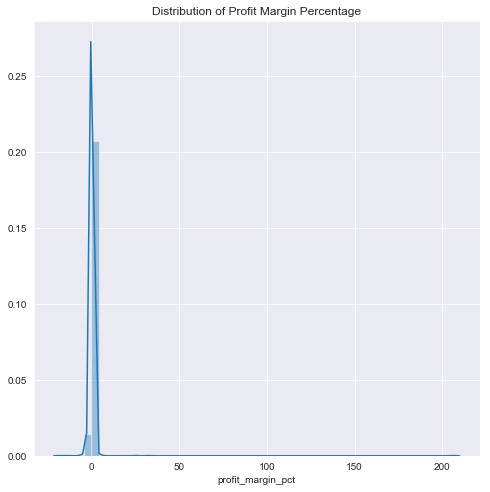

In [11]:
plt.figure(figsize=(8, 8))
sns.distplot(df['profit_margin_pct'], hist=True, kde=True)
plt.title('Distribution of Profit Margin Percentage')
plt.show();

Although this is our cleaned dataset, some outliers still persist. Remember that in our data cleaning phase, we did not want to lose too much data during data cleaning, so outliers were reduced but some still remained. For our EDA, let's just focus on a range of values and explore that. We'll create the range mask below.

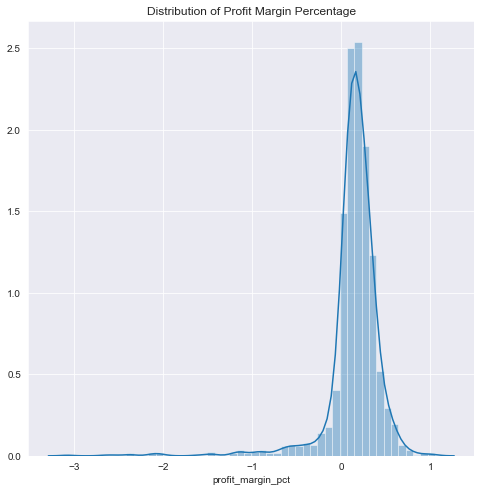

In [12]:
plt.figure(figsize=(8, 8))
mask = (
    (df['profit_margin_pct'] >= df['profit_margin_pct'].quantile(.005)) 
    & (df['profit_margin_pct'] <= df['profit_margin_pct'].quantile(.995))
)
sns.distplot(df[mask]['profit_margin_pct'], hist=True, kde=True)
plt.title('Distribution of Profit Margin Percentage')
plt.show();

The above distribution of the 0.05% - 99.5% quantile values looks a lot better for analysis.

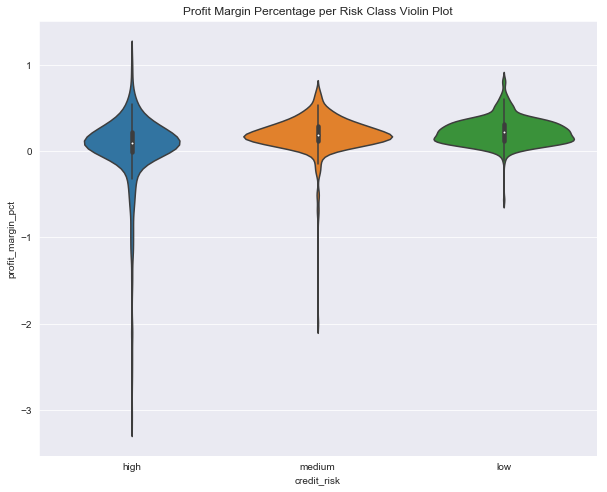

In [13]:
plt.figure(figsize=(10, 8))
sns.violinplot(df[mask]['credit_risk'], df[mask]['profit_margin_pct'])
plt.title('Profit Margin Percentage per Risk Class Violin Plot')
plt.show();

The above violin plot reflects a clear pattern for this metric. We can see the distribution get more stable and clustered in the positive end as we shift from high to low credit risk. In the high risk class, we see that the majority of the distribution is clustered more or less around 0, with a number of outliers stretching the tips vertically. We'd expect this since high credit risk companies are relatively unstable. For growth companies, profit margins can be very high, but credit risk can still remain high, just due to the unclear nature of which direction the company is really headed in the long run. For the medium risk class, we see a tighter violin, with the majority of the distribution slightly above 0, but there are still some poorly performing companies pulling the lower tip down. These outliers may still be in the medium risk class because of other factors that are favorable, or they may actually be on the brink of being downgraded to a high risk class. For the low risk class, we see the most favorable distribution, with the majority of the distribution also above 0, but clustered further up than that of the medium class. The lower tip of this violin (the outlier) also isn't stretched too low. Overall it is the most stable distribution, as expected.

**3. What are the relationships of key debt ratios to credit risk levels in our dataset?**

Debt ratios are obviously key in deriving credit risk. Things like how much debt a company has, how much debt they can take on, how much debt they can pay off in a short period of time etc. are all important considerations. From our dataset, we'll take a look at 2 derived debt ratios, 1.) the debt ratio to EBIT per revenue ratio, and 2.) the free cash flow per share to debt ratio ratio.

In [14]:
#calculate new ratios
df['debtRatio_ebitPerRevenue_ratio'] = df['debtRatio']/df['ebitPerRevenue']
df['fcf_debtRatio_ratio'] = df['freeCashFlowPerShare']/df['debtRatio']
debt_ratios = {
    'Debt Ratio to EBIT Per Revenue Ratio': 'debtRatio_ebitPerRevenue_ratio',
    'Free Cash Flow to Debt Ratio Ratio': 'fcf_debtRatio_ratio'
}

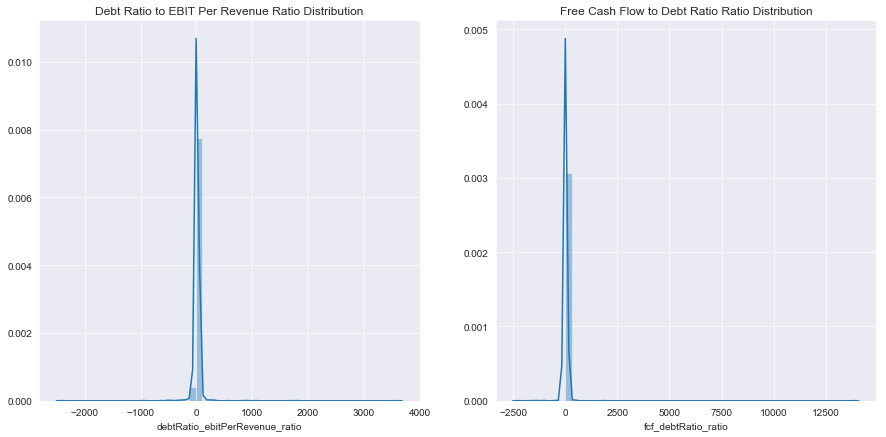

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
for i, (name, ratio) in enumerate(debt_ratios.items()):
    sns.distplot(df[ratio], hist=True, kde=True, ax=ax[i])
    ax[i].set_title(f'{name} Distribution')
plt.show();

We'll need to create masks again to address our outliers. Let's set the masks to keep the values in the 2.5% - 97.5% quantile.

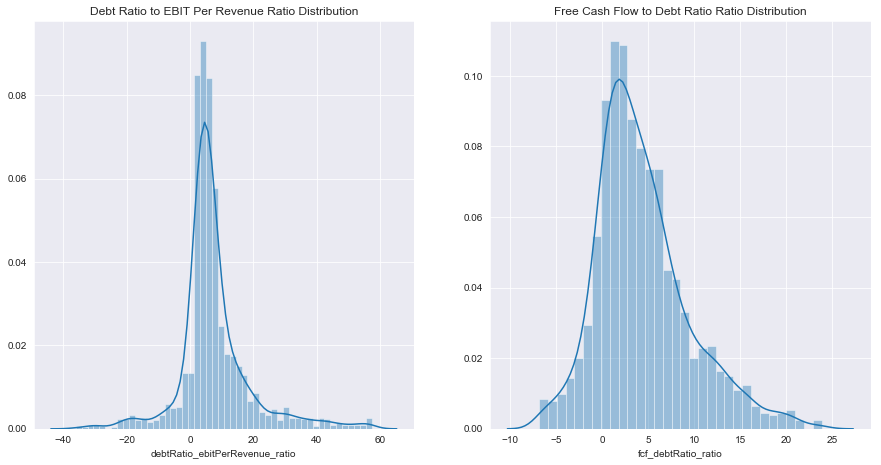

In [16]:
#Create empty dict for storing masks for df columns
#to be used in violin plot creation
mask_dict = {}
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
for i, (name, ratio) in enumerate(debt_ratios.items()):
    mask = (df[ratio] >= df[ratio].quantile(.025)) & (df[ratio] <= df[ratio].quantile(.975))
    sns.distplot(df[mask][ratio], hist=True, kde=True, ax=ax[i])
    ax[i].set_title(f'{name} Distribution')
    mask_dict[ratio] = mask
plt.show();

Better distributions, but some kurtosis persists. We'll continue on with the analysis.

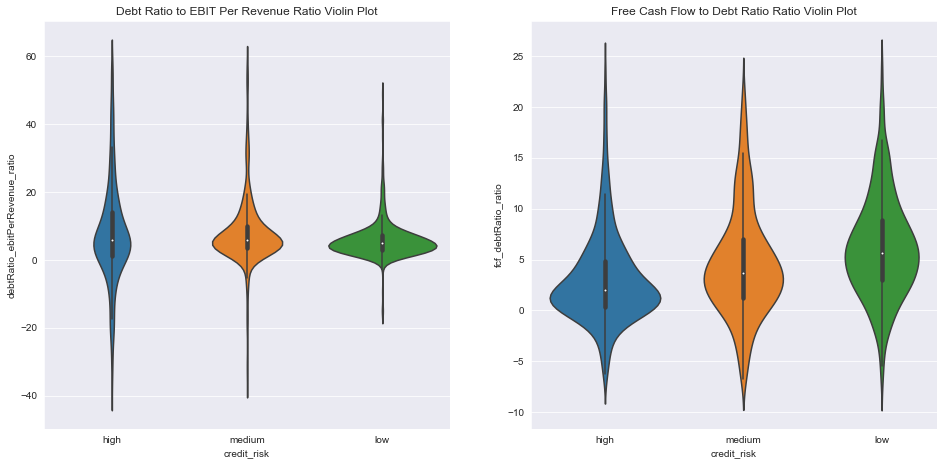

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7.5))
for i, (ratio, mask) in enumerate(mask_dict.items()):
    sns.violinplot(
        df[mask]['credit_risk'], 
        df[mask][ratio],
        ax=ax[i]
    )
    name = {v: k for k, v in debt_ratios.items()}.get(ratio)
    ax[i].set_title(f'{name} Violin Plot')
plt.plot();

For the first metric, the Debt Ratio to EBIT Per Revenue Ratio, a lower number is favorable, as it signals lower debt per earnings. We see a pattern where as we move from high to low risk, the distributions start to cluster tighter around 0. 

Conversely, for Free Cash Flow to Debt Ratio ratio, a higher number is more favorable, as the debt ratio is now the denominator, and a high number signals a healthier cash flow relative to debt. We observe that as we move from high to low risk, the distribution spreads out thinner vertically and above 0. 

**4. What are the relationships between key liquidity ratios and credit risk levels in our dataset?**

Liquidity ratios essentially measure a company's ability to pay off its short-term obligations. Our dataset has 3 liquidity ratio indicators: the current ratio, quick ratio, and cash ratio. While these metrics are similar, they are not the same. Nevertheless, from a machine learning standpoint, these variables are all collinear, and we'll see that below.

In [18]:
liquidity_ratios = {
    'Current Ratio': 'currentRatio',
    'Quick Ratio': 'quickRatio',
    'Cash Ratio': 'cashRatio'
}

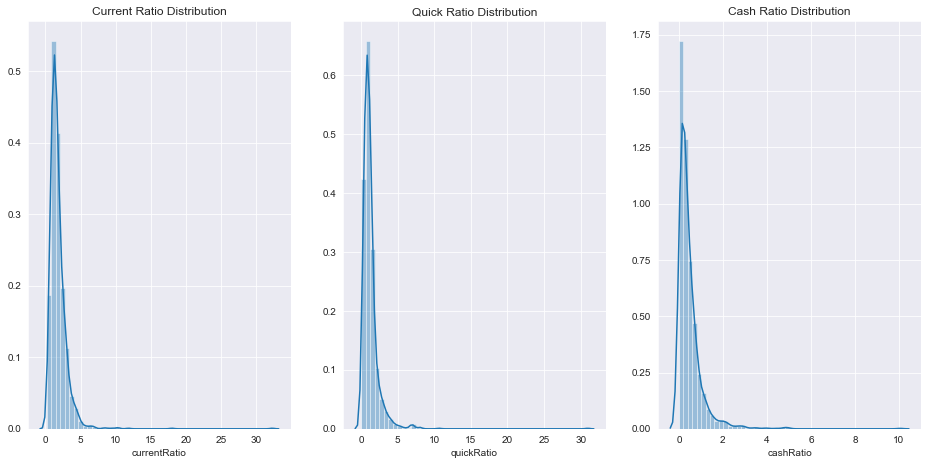

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(16, 7.5))
for i, (name, ratio) in enumerate(liquidity_ratios.items()):
    sns.distplot(df[ratio], hist=True, kde=True, ax=ax[i])
    ax[i].set_title(f'{name} Distribution')
plt.show();

All of these distributions have heavy right tails, so we'll need to mask again. However, we'll do it in a biased way where only the values in the right tail get cut off. We'll set the mask to retain the values in the 0% - 99.5% percentile.

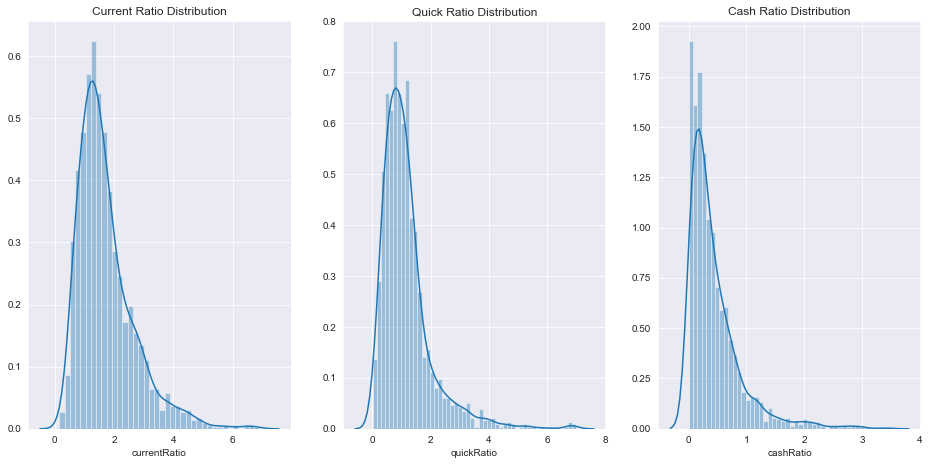

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(16, 7.5))
mask_dict = {}
for i, (name, ratio) in enumerate(liquidity_ratios.items()):
    mask = (df[ratio] >= df[ratio].quantile(0)) & (df[ratio] <= df[ratio].quantile(0.995))
    sns.distplot(df[mask][ratio], hist=True, kde=True, ax=ax[i])
    ax[i].set_title(f'{name} Distribution')
    mask_dict[ratio] = mask
plt.show();

We've succesfully removed the extreme outliers. However, the data is still skewed. This is okay as we might actually want to see which class generally has heavier tails naturally.

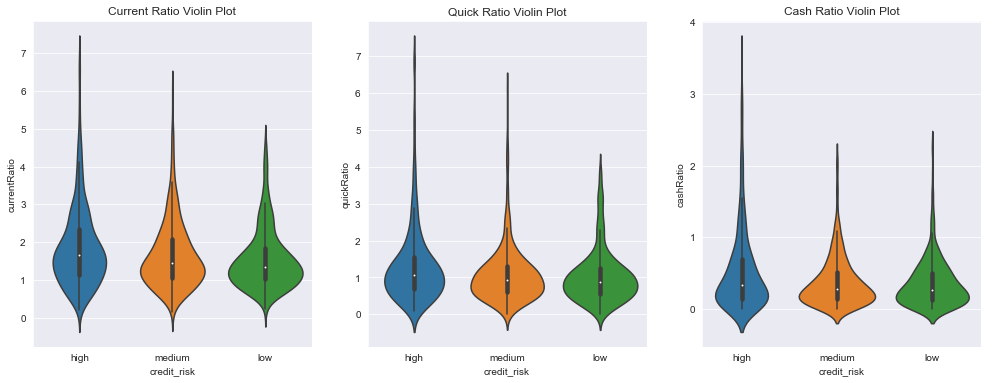

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(17, 6))
for i, (ratio, mask) in enumerate(mask_dict.items()):
    sns.violinplot(
        df[mask]['credit_risk'], 
        df[mask][ratio],
        ax=ax[i]
    )
    name = {v: k for k, v in liquidity_ratios.items()}.get(ratio)
    ax[i].set_title(f'{name} Violin Plot')
plt.plot();


The patterns are less apparent this these metrics. The medium and low risk classes seem to be pretty similar, except with the medium class having a few outliers in the right tail of the distribution stretching the violin upwards. This is more apparent in the high risk class, where the distributions are indeed stretching out upwards vertically, and containing the highest outliers. This can be due to the fact that for companies with higher credit risk, lenders may require the company to abide by stricter covenants, especially covenants with respect to the company's ongoing liquidity profile. For low credit risk companies, lenders are a bit more lax as they're confident in the company's ability to pay off its obligations, and in a reasonable amount of time.

### EDA Conclusion

We've only explored a few key features in our dataset relative to the total number of features we're working with. Although the above questions only looked at a few features at a time, in reality these are certainly not enough, as there are a ton of other factors at play. The actual model would do a better job considering all of the features. The above questions serve as good data integrity checks, as the patterns we observed are in line with some of the general notions of credit risk determination factors that we know. 